<div class='alert alert-info'>
    <b>Importing Libraries<b>

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

<div class='alert alert-info'>
    <b>Importing Data & Preprocessing<b>

In [34]:
df = pd.read_excel("Immunotherapy.xlsx")
df

,sex,age,Time,Number_of_Warts,Type,Area,induration_diameter,Result_of_Treatment
0,1,22,2.25,14,3,51,50,1
1,1,15,3.00,2,3,900,70,1
2,1,16,10.50,2,1,100,25,1
3,1,27,4.50,9,3,80,30,1
4,1,20,8.00,6,1,45,8,1
...,...,...,...,...,...,...,...,...
85,1,40,5.50,8,3,69,5,1
86,1,38,7.50,8,2,56,45,1
87,1,46,11.50,4,1,91,25,0
88,1,32,12.00,9,1,43,50,0


In [35]:
# feature engineering
df['sex'] = df['sex'].map({1:'Male',2:'Female'})
df['Result_of_Treatment'] = df['Result_of_Treatment'].map({1:'Successful',0:'Fail'})
df['Type'] = df['Type'].map({1:'Common',2:'Plantar',3:'Both'})

In [38]:
# creating a list of numerical cols
num_feats = [i for i in df if df[i].dtypes=='O']
num_feats.pop(-1)

# ordinal encoding the values and label encoding the target variable
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
for i in df[num_feats]:
    df[i] = OrdinalEncoder().fit_transform(df[i].values.reshape(-1,1))
    
df['Result_of_Treatment'] = LabelEncoder().fit_transform(df.Result_of_Treatment.values)

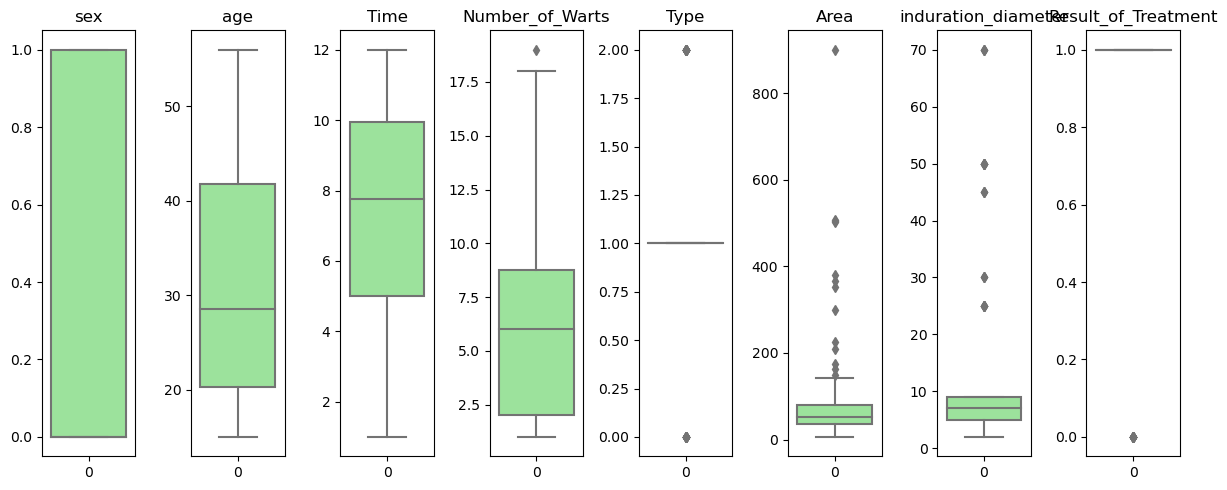

In [46]:
# outliers
collist = df.columns.values
nrows = 1
ncols = 8

plt.figure(figsize=(12,5))
for i in range(0,len(collist)):
    plt.subplot(nrows,ncols,i+1)
    sns.boxplot(data = df[collist[i]], orient='v', color='lightgreen')
    plt.title(collist[i])
    plt.tight_layout()

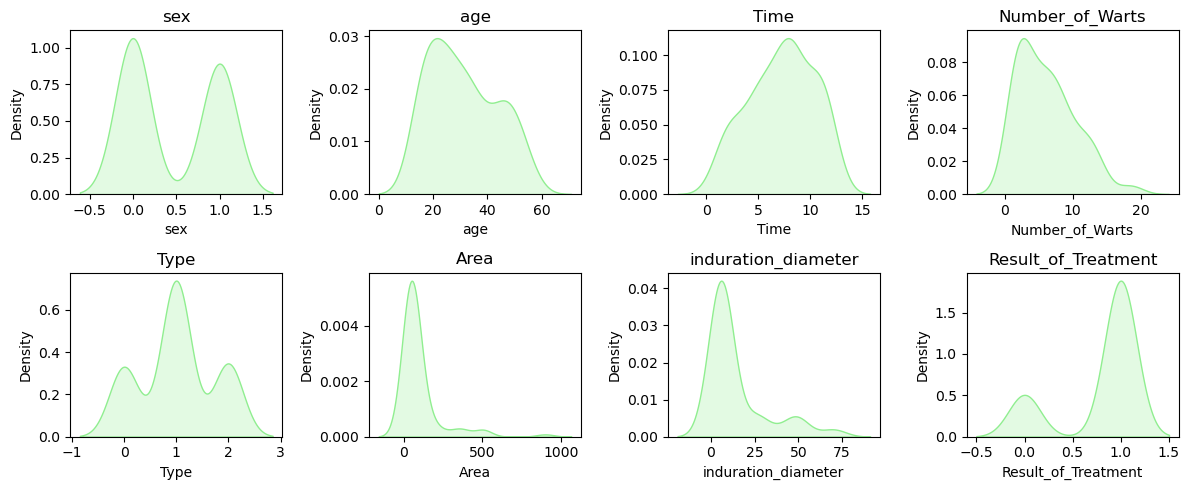

In [41]:
# skewness
collist = df.columns.values
nrows = 2
ncols = 4

plt.figure(figsize=(12,5))
for i in range(0,len(collist)):
    plt.subplot(nrows,ncols,i+1)
    sns.kdeplot(df[collist[i]], fill=True, color='lightgreen')
    plt.title(collist[i])
    plt.tight_layout()

In [45]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame({'Columns':df.columns.values,'VIF_Factor':[variance_inflation_factor(df.values,i) for i in range(df.shape[1])]})
vif

,Columns,VIF_Factor
0,sex,1.812391
1,age,6.349451
2,Time,6.142903
3,Number_of_Warts,2.971824
4,Type,3.472906
5,Area,1.535721
6,induration_diameter,1.702896
7,Result_of_Treatment,3.320919


<div class='alert alert-info'>
    <b>Remocing Outliers<b>

In [69]:
# removing outliers using zscore
from scipy.stats import zscore

z = np.abs(zscore(df))
df_new = df[(z<3).all(axis=1)]
print ("The amount of data loss (%):",(df.shape[0]-df_new.shape[0])/df.shape[0]*100,'%')

The amount of data loss (%): 6.666666666666667 %


In [70]:
# removing outliers using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3-Q1

df_IQR = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
print ("Percentage of data loss =",(df.shape[0]-df_IQR.shape[0])/df.shape[0]*100,'%')

Percentage of data loss = 73.33333333333333 %


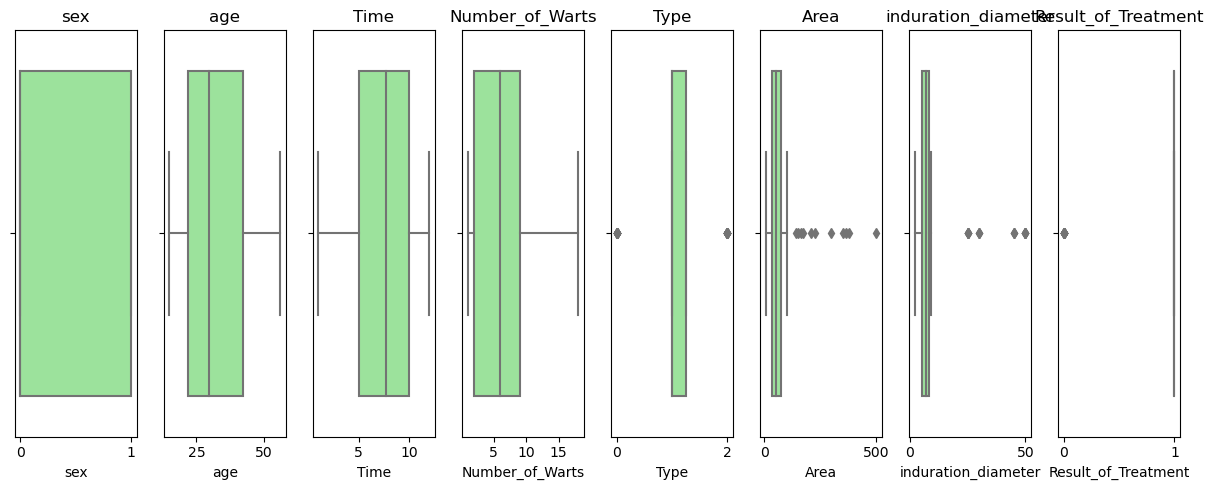

In [72]:
# outliers after zscore
collist = df_new.columns.values
nrows = 1
ncols = 8

plt.figure(figsize=(12,5))
for i in range(0,len(collist)):
    plt.subplot(nrows,ncols,i+1)
    sns.boxplot(df_new[collist[i]], orient='v', color='lightgreen')
    plt.title(collist[i])
    plt.tight_layout()

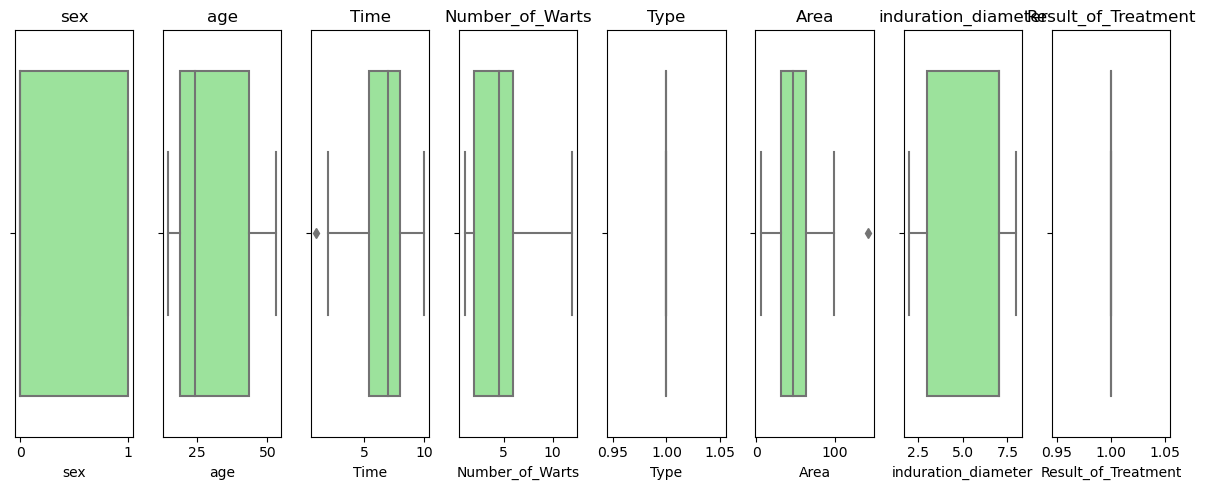

In [73]:
# outliers after IQR
collist = df_IQR.columns.values
nrows = 1
ncols = 8

plt.figure(figsize=(12,5))
for i in range(0,len(collist)):
    plt.subplot(nrows,ncols,i+1)
    sns.boxplot(df_IQR[collist[i]], orient='v', color='lightgreen')
    plt.title(collist[i])
    plt.tight_layout()

<div class='alert alert-info'>
    <b>Splitting into x & y<b>

In [122]:
x = df.drop('Result_of_Treatment',axis=1)
y = df.Result_of_Treatment

In [123]:
# scaling and transforming
from sklearn.preprocessing import StandardScaler, power_transform

x = StandardScaler().fit_transform(x)
# x = power_transform(x,method='yeo-johnson')

<div class='alert alert-info'>
    <b>Model Building<b>

In [157]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [153]:
# from imblearn.over_sampling import SMOTE
# x_train, y_train = SMOTE().fit_sample(x_train,y_train)
# y_train.value_counts()

In [154]:
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test,y_pred):
    LB = LabelBinarizer()
    LB_y_test = LB.fit_transform(y_test)
    LB_y_pred = LB.fit_transform(y_pred)
    return round(roc_auc_score(LB_y_test,LB_y_pred)*100,2)

In [140]:
# making a function for classification models
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV

Model, score, f1, cross, roc_auc = [], [], [], [], []

def classification_model(model):
    Model.append(str(model).split("(")[0])
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    
    scoree = round(accuracy_score(y_test,y_pred)*100,2)
    score.append(scoree)
    
    f1_s = round(f1_score(y_test,y_pred,average='micro')*100,2)
    f1.append(f1_s)
    
    cross_v = cross_val_score(model,x,y,cv=10,scoring='accuracy').mean()
    cross.append(cross_v)
    
    roc_ = multiclass_roc_auc_score(y_test,y_pred)
    roc_auc.append(roc_)
    
    print ("Model:",str(model).split("(")[0])
    print ("Accuracy Score:",scoree)
    print ("f1 Score:",f1_s)
    print ("CV Score:",cross_v)
    print ("ROC_AUC Score:",roc_)

#      shows the classification report
    class_report = classification_report(y_test,model.predict(x_test))
    print (class_report)
    
    
#     shows the confusion matrix
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,square=True)

In [158]:
#Random Forest Classisfier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc_para = {'n_estimators':range(100,600,50),'criterion':['gini','entropy','log_loss']}
gsCV_rfc = GridSearchCV(rfc,rfc_para,cv=7,scoring='accuracy')
gsCV_rfc.fit(x_train,y_train)
gsCV_rfc.best_params_

{'criterion': 'gini', 'n_estimators': 150}

Model: RandomForestClassifier
Accuracy Score: 94.44
f1 Score: 94.44
CV Score: 0.8666666666666668
ROC_AUC Score: 83.33
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.94      1.00      0.97        15

    accuracy                           0.94        18
   macro avg       0.97      0.83      0.88        18
weighted avg       0.95      0.94      0.94        18



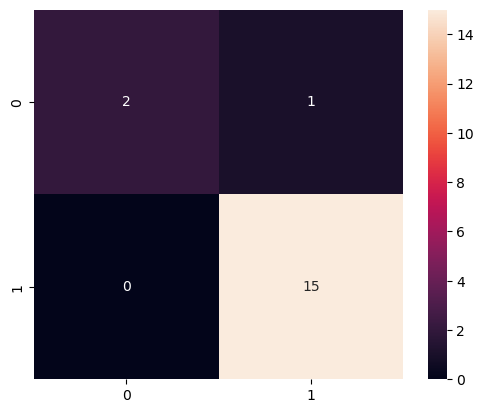

In [159]:
rfc = RandomForestClassifier(criterion='gini',n_estimators=150)
classification_model(rfc)

In [160]:
rfc = RandomForestClassifier(criterion='gini',n_estimators=400)
rfc.fit(x_train,y_train)
rfc_y_pred = rfc.predict(x_test)
rfc_score = accuracy_score(y_test,rfc_y_pred)

print ("Test Score:",round(rfc_score*100,2),'%')

Test Score: 94.44 %


<div class='alert alert-info'>
    <b>Actual vs Predicted<b>

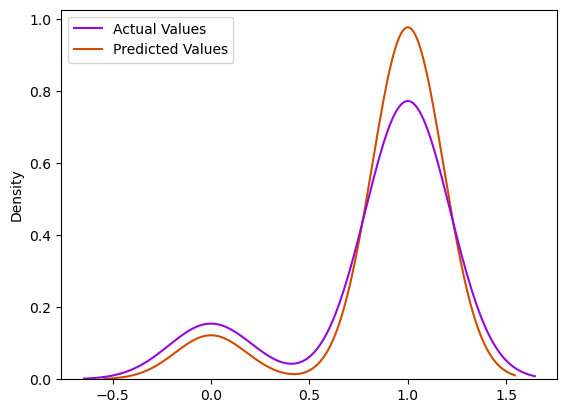

In [161]:
actualVSpredicted = pd.DataFrame({'Actual Values':y_test,'Predicted Values':rfc_y_pred})
sns.kdeplot(data=actualVSpredicted,palette='gnuplot')
plt.show()

<div class='alert alert-info'>
    <b>ROC Curve and Feature Importance<b>

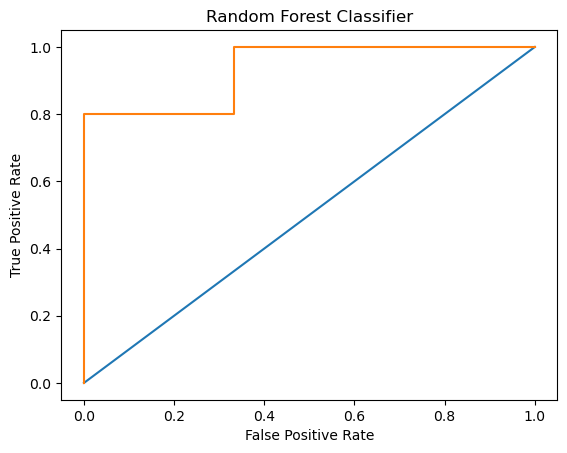

In [162]:
# Plotting ROC Curve for the model
from sklearn.metrics import roc_curve
y_pred_prob = rfc.predict_proba(x_test)[:,1]  #1 is the probabilty of threshold value
fpr,tpr,thresholds = roc_curve(y_test,y_pred_prob)

plt.plot([0,1],[0,1])
plt.plot(fpr,tpr,label='Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Classifier')
plt.show()

<AxesSubplot:>

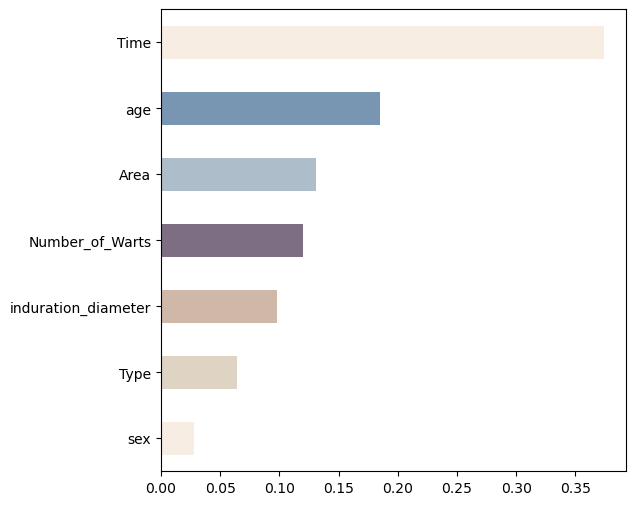

In [164]:
# Feature importance of the classifier
pd.Series(rfc.feature_importances_, index = df_new.columns[:-1]).sort_values(ascending=True).plot(kind='barh', figsize=(6,6),
                                                                                               color=(['#F8EDE3','#DFD3C3',
                                                                                                     '#D0B8A8','#7D6E83',
                                                                                                      '#AEBDCA','#7895B2']))

<div class='alert alert-info'>
    <b>Saving the model file<b>

In [167]:
import pickle
pickle.dump(rfc,open('RFC_immunotherapy.pkl','wb'))

In [168]:
pickled_model = pickle.load(open('RFC_immunotherapy.pkl','rb'))